In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import multiprocessing

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from phylo_gnn import get_data_path
from phylo_gnn.encoding import VectorTree

In [4]:
df = pd.read_csv(get_data_path() / "raw" / "489_10k_nwk.csv")

In [5]:
# Sample a subset of the data
# df = df.sample(1000, random_state=42)

In [6]:
df.head()

,nwk,label
0,"((((((((197:0.944288,(311:0.821147,312:0.82114...",0
1,"(((((31:6.62518,((105:4.91516,((275:0.643727,2...",0
2,"((((((((((((((((919:0.545101,(955:0.455584,956...",0
3,"((((((43:0.899426,(79:0.727872,80:0.727872)44:...",0
4,"(((((((109:0.774441,(183:0.535652,184:0.535652...",0


In [7]:
vector_trees = [
    VectorTree.from_newick(row["nwk"])
    for _, row in tqdm.tqdm(
        df.iterrows(), total=len(df), desc="Encoding trees"
    )
]

Encoding trees: 100%|██████████| 60000/60000 [06:06<00:00, 163.85it/s]


In [8]:
avg_branch_lengths = np.array(
    [np.mean(tree.branch_lengths) for tree in vector_trees],
)

In [9]:
# add "rescale_factor" column to the dataframe
df["rescale_factor"] = avg_branch_lengths

In [10]:
df

,nwk,label,rescale_factor
0,"((((((((197:0.944288,(311:0.821147,312:0.82114...",0,0.998082
1,"(((((31:6.62518,((105:4.91516,((275:0.643727,2...",0,0.999762
2,"((((((((((((((((919:0.545101,(955:0.455584,956...",0,0.998971
3,"((((((43:0.899426,(79:0.727872,80:0.727872)44:...",0,0.994622
4,"(((((((109:0.774441,(183:0.535652,184:0.535652...",0,0.993369
...,...,...,...
59995,"((((15:5.18239,(((((((((((871:0.424783,(927:0....",5,0.999397
59996,"((((((((((((((715:0.317609,716:0.317609)621:0....",5,0.999986
59997,"((((((((((((667:0.709392,(783:0.521597,784:0.5...",5,0.998866
59998,"((((((((93:0.350582,94:0.350582)59:3.8663,60:4...",5,0.999413


In [11]:
df_without_nwk = df.drop(columns=["nwk"])
# group by "label" and aggregate the "rescale_factor" column
# with mean, std, min, and max
grouped_df = df_without_nwk.groupby("label").aggregate(
    {"rescale_factor": ["mean", "std", "min", "max", "count"]}
)
grouped_df

rescale_factor                                
                mean       std       min  max  count
label                                               
0           0.997582  0.002415  0.979517  1.0  10000
1           0.993836  0.006266  0.930751  1.0  10000
2           0.996994  0.003101  0.969564  1.0  10000
3           0.999688  0.000322  0.996298  1.0  10000
4           0.975819  0.035138  0.538054  1.0  10000
5           0.999677  0.000400  0.993599  1.0  10000

In [12]:
min_branch_lengths = np.array(
    [np.min(tree.branch_lengths) for tree in vector_trees],
)
max_branch_lengths = np.array(
    [np.max(tree.branch_lengths) for tree in vector_trees],
)
std_branch_lengths = np.array(
    [np.std(tree.branch_lengths) for tree in vector_trees],
)
# add "min_branch_length", "max_branch_length", and "std_branch_length" columns to the dataframe
df["min_branch_length"] = min_branch_lengths
df["max_branch_length"] = max_branch_lengths
df["std_branch_length"] = std_branch_lengths
# group by "label" and aggregate the "min_branch_length", "max_branch_length", and "std_branch_length" columns
grouped_df = df.groupby("label").aggregate(
    {
        "max_branch_length": ["mean", "std", "min", "max"],
        "std_branch_length": ["mean", "std", "min", "max"],
    }
)

grouped_df

max_branch_length                                 std_branch_length  \
                   mean        std      min         max              mean   
label                                                                       
0              8.165362   1.594377  4.54500   20.630899          1.054209   
1             14.868283   3.821575  7.16179   46.442200          1.484789   
2             12.396483   3.360038  5.60985   38.214901          1.330792   
3              3.005793   0.267044  2.36945    4.723020          0.796897   
4             27.204599  20.163805  5.63786  210.860992          1.794919   
5              4.063900   0.847932  2.37807    8.485890          1.089216   

                                     
            std       min       max  
label                                
0      0.057642  0.889318  1.364458  
1      0.127316  1.125765  2.209331  
2      0.159710  0.959525  2.062661  
3      0.019512  0.730614  0.887950  
4      0.862191  0.831589  9.245891  
5      0.162684  0.748794  1.731297

In [13]:
X = df[["max_branch_length", "std_branch_length"]]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [28]:
y_pred = rf.predict(X_test)
LABEL_NAMES = ["BD", "HE", "ME", "SAT", "SR", "WW"]
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))

              precision    recall  f1-score   support

          BD       0.80      0.87      0.83      1494
          HE       0.64      0.72      0.67      1475
          ME       0.56      0.52      0.54      1476
         SAT       0.99      0.99      0.99      1554
          SR       0.77      0.66      0.71      1491
          WW       0.98      0.99      0.99      1510

    accuracy                           0.79      9000
   macro avg       0.79      0.79      0.79      9000
weighted avg       0.79      0.79      0.79      9000



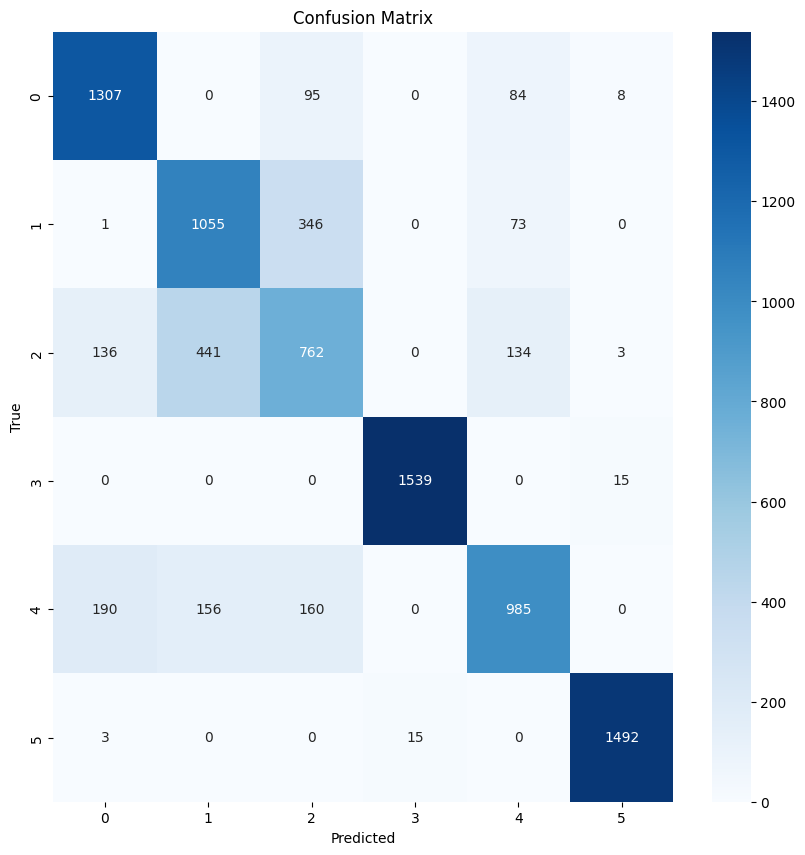

In [15]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

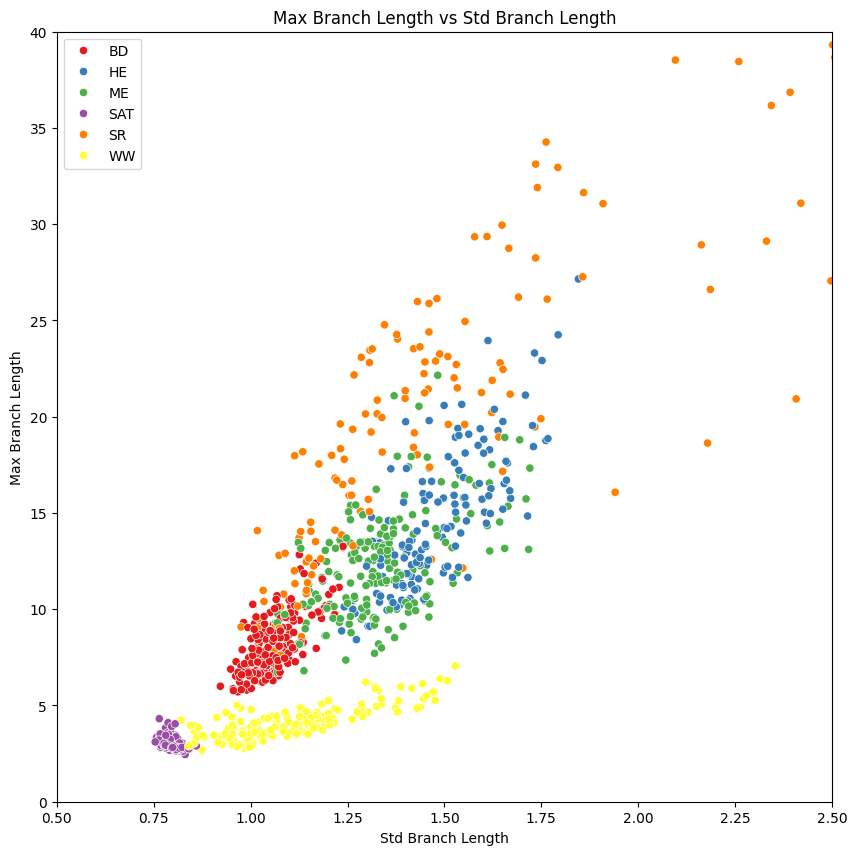

In [ ]:
# plot in the x axis the max branch length and in the y axis the std branch length
# and color the points by the label


# Assuming df has numeric labels from 0-5, create a copy and map the integers to names
plot_df = df.copy().sample(1000, random_state=42)
plot_df["label_name"] = plot_df["label"].map(lambda x: LABEL_NAMES[x])
# sort by the label name
plot_df["label_name"] = pd.Categorical(
    plot_df["label_name"], categories=LABEL_NAMES, ordered=True
)

# Create the plot
plt.figure(figsize=(10, 10))
sns.scatterplot(
    y="max_branch_length",
    x="std_branch_length",
    hue="label_name",  # Use the text labels instead of integers
    data=plot_df,
    palette="Set1",
)
plt.title("Max Branch Length vs Std Branch Length")
plt.xlabel("Std Branch Length")
plt.ylabel("Max Branch Length")
plt.legend(loc="upper left")
# x limit from 0 to 2.5
plt.xlim(0.5, 2.5)
# y limit from 0 to 50
plt.ylim(0, 40)

# save the figure
plt.savefig(
    get_data_path().parent / "images" / "max_std_branch_length.png", dpi=300
)
plt.show()